<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 56


Chromosome 16


Apply ```HMM_Model_9.json``` in regions: 

* [R1: ```region_0_REGION_1_CHR_16_MEAN_CUTOFF.txt```,  1000000-20000000](#r1)
* [R2: ```region_0_REGION_2_CHR_16_MEAN_CUTOFF.txt```,  20000000-30000000](#r2) 
* [R3: ```region_0_REGION_3_CHR_16_MEAN_CUTOFF.txt```,  40000000-60000000](#r3)
* [R4: ```region_0_REGION_4_CHR_16_MEAN_CUTOFF.txt```,  60000000-80000000](#r4)
* [R5: ```region_0_REGION_5_CHR_16_MEAN_CUTOFF.txt```,  80000000-90000000](#r5)


In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


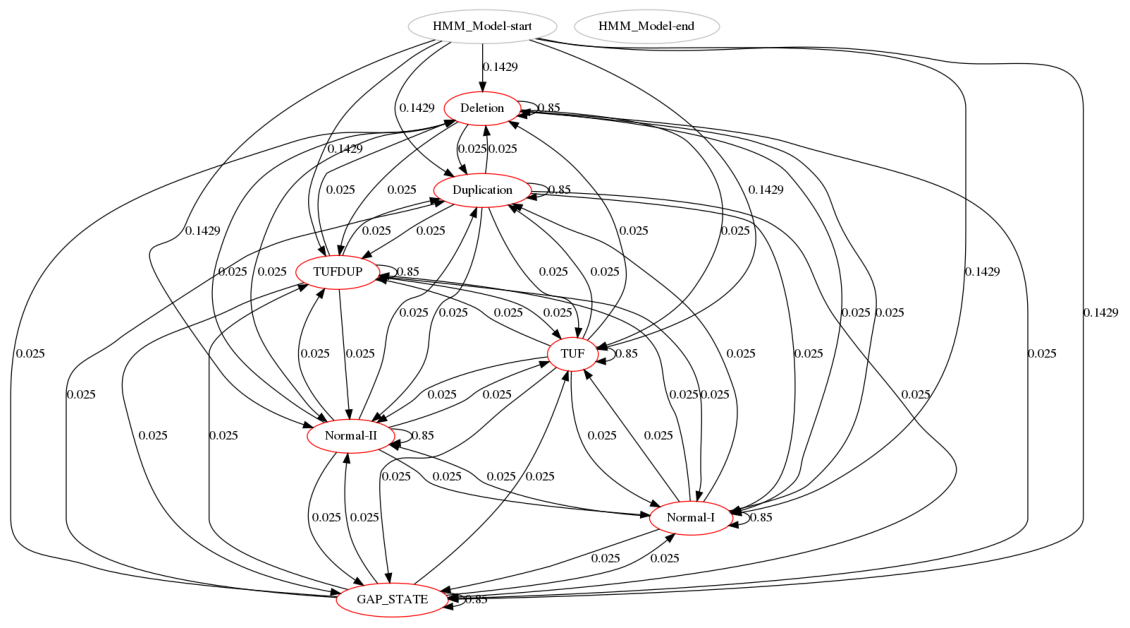

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [7]:
chr='chr16'
viterbi_paths = 'viterbi_paths_chr16/'


In [8]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_16_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_16_MEAN_CUTOFF.txt
Sequence length:  189998


In [9]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr=chr,
                                                                         filename=filename)

Observation length:  189998
Done. Execution time 0.6643371749996732 secs
Log-probability of ML Viterbi path:  -1285102.819940668
Viterbi path length:  189999
There should be 501 gaps


In [10]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

Length of path  189998
Length of TUF+DELETION+TUF state:  4210


In [11]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  189497
Encountered gaps:  501


In [12]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 558, 'Normal-I': 125086, 'Normal-II': 55992, 'Deletion': 296, 'Single-Deletion': 0, 'TUF': 7565, 'GAP_STATE': 501, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


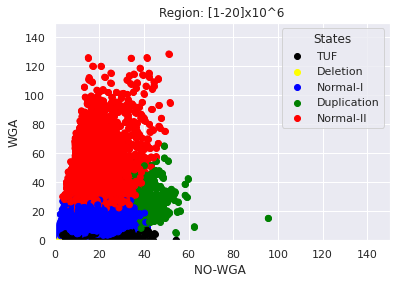

HMM labels color:  {'black': [5, 7565], 'yellow': [3, 296], 'blue': [1, 125086], 'green': [0, 558], 'red': [2, 55992]}


In [13]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-20]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [14]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  25.84867383512545 67.68153229146593
NO-WGA mean/var:  38.41270609318997 46.08067851935356
State:  Normal-I
WGA mean/var:  15.67831811713541 29.685634153826033
NO-WGA mean/var:  16.528346897334632 21.040889010532204
State:  Normal-II
WGA mean/var:  33.05270467209601 91.21521762045394
NO-WGA mean/var:  18.305534719245603 19.537280600630552
State:  Deletion
WGA mean/var:  0.9768918918918917 1.4196626369612857
NO-WGA mean/var:  2.1799999999999997 1.9526804054054052
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.379929940515532 2.5902828106898177
NO-WGA mean/var:  14.32746199603437 24.13405655919681
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_16_MEAN_CUTOFF.txt
Sequence length:  100000
Observation length:  100000
Done. Execution time 0.5074995810009568 secs
Log-probability of ML Viterbi path:  -706761.7812185115
Viterbi path length:  100001
There should be 0 gaps
Length of path  100000
Length of TUF+DELETION+TUF state:  217
Length of WGA Observations:  100000
Encountered gaps:  0
{'Duplication': 1062, 'Normal-I': 59571, 'Normal-II': 38371, 'Deletion': 90, 'Single-Deletion': 0, 'TUF': 906, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


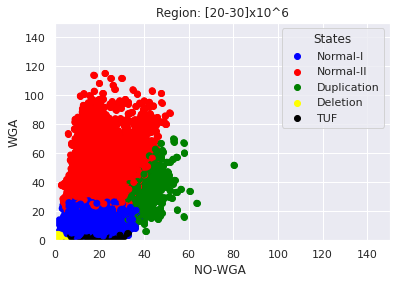

HMM labels color:  {'blue': [1, 59571], 'red': [2, 38371], 'green': [0, 1062], 'yellow': [3, 90], 'black': [5, 906]}
State:  Duplication
WGA mean/var:  31.882721280602635 94.54980737805937
NO-WGA mean/var:  37.50806026365348 35.69958380804437
State:  Normal-I
WGA mean/var:  16.483781705863592 27.227521049794415
NO-WGA mean/var:  17.01460425374763 22.059203336275743
State:  Normal-II
WGA mean/var:  34.66302650439134 119.9816264948019
NO-WGA mean/var:  18.857154882593623 28.178967212179316
State:  Deletion
WGA mean/var:  1.4429999999999998 1.5479943333333333
NO-WGA mean/var:  2.1624444444444446 2.1062429135802474
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.7466445916114792 2.178465562426599
NO-WGA mean/var:  15.225165562913908 22.142138438372587
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [15]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_16_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [20-30]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_16_MEAN_CUTOFF.txt
Sequence length:  199800
Observation length:  199800
Done. Execution time 0.6832399140002963 secs
Log-probability of ML Viterbi path:  -940882.6804670554
Viterbi path length:  199801
There should be 63807 gaps
Length of path  199800
Length of TUF+DELETION+TUF state:  216
Length of WGA Observations:  135993
Encountered gaps:  63807
{'Duplication': 63, 'Normal-I': 91409, 'Normal-II': 43070, 'Deletion': 44, 'Single-Deletion': 0, 'TUF': 1403, 'GAP_STATE': 63807, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 4}


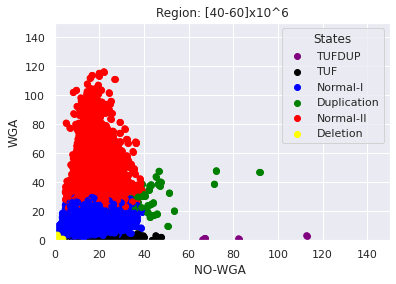

HMM labels color:  {'purple': [6, 4], 'black': [5, 1403], 'blue': [1, 91409], 'green': [0, 63], 'red': [2, 43070], 'yellow': [3, 44]}
State:  Duplication
WGA mean/var:  28.566666666666666 67.69475555555555
NO-WGA mean/var:  39.953968253968256 113.44073187200804
State:  Normal-I
WGA mean/var:  16.79731437823409 25.12438052277908
NO-WGA mean/var:  17.827281668107076 21.44581334167195
State:  Normal-II
WGA mean/var:  32.43441003018342 81.80249899138302
NO-WGA mean/var:  18.57684397492454 18.95574629443955
State:  Deletion
WGA mean/var:  1.8438636363636363 1.6411009814049586
NO-WGA mean/var:  2.1227272727272726 1.350819834710744
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.3634141126158235 2.5175238392021173
NO-WGA mean/var:  16.443214540270848 43.46895552560469
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  1.4475 1.11946875
NO-WGA mean/var:  82.22 354.93709999999993


In [16]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_16_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [40-60]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_16_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.5005947930003458 secs
Log-probability of ML Viterbi path:  -1352701.7685374885
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  272
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 393, 'Normal-I': 145389, 'Normal-II': 53156, 'Deletion': 250, 'Single-Deletion': 0, 'TUF': 812, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


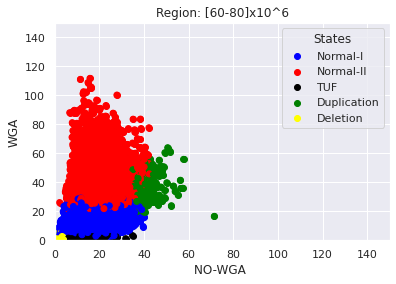

HMM labels color:  {'blue': [1, 145389], 'red': [2, 53156], 'black': [5, 812], 'green': [0, 393], 'yellow': [3, 250]}
State:  Duplication
WGA mean/var:  31.94015267175573 74.45070786473205
NO-WGA mean/var:  37.152697201017816 35.826386109330585
State:  Normal-I
WGA mean/var:  16.54871482711897 24.292259172051857
NO-WGA mean/var:  18.09355363885851 21.719919446291996
State:  Normal-II
WGA mean/var:  31.635418203025058 67.5800848898214
NO-WGA mean/var:  19.086157536308225 20.66303281429737
State:  Deletion
WGA mean/var:  0.42052000000000006 0.9383649296
NO-WGA mean/var:  0.54216 1.2985841344
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.6981650246305415 2.394902421042733
NO-WGA mean/var:  14.743571428571427 26.158063353272343
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [17]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_16_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [60-80]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r5"></a>  Region 5

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_5_CHR_16_MEAN_CUTOFF.txt
Sequence length:  99999
Observation length:  99999
Done. Execution time 0.25472851100130356 secs
Log-probability of ML Viterbi path:  -665787.6274526013
Viterbi path length:  100000
There should be 0 gaps
Length of path  99999
Length of TUF+DELETION+TUF state:  3829
Length of WGA Observations:  99999
Encountered gaps:  0
{'Duplication': 29, 'Normal-I': 67193, 'Normal-II': 24567, 'Deletion': 299, 'Single-Deletion': 0, 'TUF': 7911, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


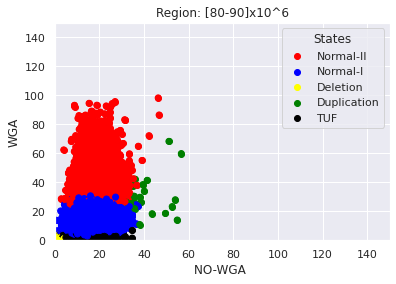

HMM labels color:  {'red': [2, 24567], 'blue': [1, 67193], 'yellow': [3, 299], 'green': [0, 29], 'black': [5, 7911]}
State:  Duplication
WGA mean/var:  29.377586206896552 143.01485279429252
NO-WGA mean/var:  39.48310344827586 58.91482829964328
State:  Normal-I
WGA mean/var:  15.136509904305507 31.57093963117674
NO-WGA mean/var:  16.257194945902107 18.854773510684204
State:  Normal-II
WGA mean/var:  33.137760817356614 88.27614492296833
NO-WGA mean/var:  18.01032971058737 18.587281317594506
State:  Deletion
WGA mean/var:  0.8374916387959868 1.0091037415688862
NO-WGA mean/var:  2.1593979933110368 1.7819554904307555
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.4080975856402476 2.609095066194399
NO-WGA mean/var:  13.544214385033497 16.59392955282556
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [18]:
# load the region we want to use for prediction
region_name = "region_0_REGION_5_CHR_16_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [80-90]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))